In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
# Load Train data from our github repo
url_train = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_train.csv'
dataDF_train = pd.read_csv(url_train)

# Load Train label data from our github repo
url_train_labels = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_train_labels.csv'
dataDF_train_labels = pd.read_csv(url_train_labels)

# Load Problem data from our github repo
url_problem = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_test.csv'
dataDF_problem = pd.read_csv(url_problem)


In [3]:
# drop indexes 
dataDF_train = dataDF_train.drop("Unnamed: 0", axis = 1)
dataDF_train_labels = dataDF_train_labels.drop("Unnamed: 0", axis = 1)
dataDF_problem = dataDF_problem.drop("Unnamed: 0", axis = 1)

In [4]:
# create tf dataset for training
train_tensor = tf.data.Dataset.from_tensor_slices(dataDF_train)
train_labels_tensor = tf.data.Dataset.from_tensor_slices(dataDF_train_labels)
train_tensor = tf.data.Dataset.zip((train_tensor, train_labels_tensor))

# create problem tf data set
problem_tensor = tf.data.Dataset.from_tensor_slices(dataDF_problem)

In [5]:
# shuffle and batch training data
train_tensor = train_tensor.shuffle(1000)

# shuffle and batch problem data
problem_tensor = problem_tensor.shuffle(1000).batch(64).prefetch(64)

In [6]:
# split training data into train, test and validation data
DATASET_SIZE = len(dataDF_train)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = train_tensor.take(train_size)
test_dataset = train_tensor.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [7]:
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(64)
test_dataset = test_dataset.shuffle(1000).batch(64).prefetch(64)
val_dataset = val_dataset.shuffle(1000).batch(64).prefetch(64)

In [8]:
# create completely basic Model
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = SimpleDense(300, activation = tf.keras.activations.sigmoid)
        self.dense2 = SimpleDense(600, activation = tf.keras.activations.sigmoid)
        self.dense3 = SimpleDense(1200, activation = tf.keras.activations.sigmoid)
        self.dense4 = SimpleDense(600, activation = tf.keras.activations.sigmoid)
        self.dense5 = SimpleDense(300, activation = tf.keras.activations.sigmoid)
        self.out = SimpleDense(1, activation = tf.keras.activations.sigmoid)
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dropout(x, training=True)
        out = self.out(x) * 500
        return out

class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs):
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x


In [9]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.round(target, 0) == np.round(prediction, 0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [10]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset
test_dataset = test_dataset

### Hyperparameters
num_epochs = 50
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch+1)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 1 starting with accuracy 0.0014534883720930232
Epoch: 2 starting with accuracy 0.0014534883720930232
Epoch: 3 starting with accuracy 0.001816860465116279
Epoch: 4 starting with accuracy 0.003997093023255814
Epoch: 5 starting with accuracy 0.0029069767441860465
Epoch: 6 starting with accuracy 0.0010901162790697674
Epoch: 7 starting with accuracy 0.001816860465116279
Epoch: 8 starting with accuracy 0.002180232558139535
Epoch: 9 starting with accuracy 0.0014534883720930232
Epoch: 10 starting with accuracy 0.003633720930232558
Epoch: 11 starting with accuracy 0.002180232558139535
Epoch: 12 starting with accuracy 0.0034355179704016916
Epoch: 13 starting with accuracy 0.0029069767441860465
Epoch: 14 starting with accuracy 0.001816860465116279
Epoch: 15 starting with accuracy 0.0029069767441860465
Epoch: 16 starting with accuracy 0.002180232558139535
Epoch: 17 starting with accuracy 0.002543604651162791
Epoch: 18 starting with accuracy 0.0029069767441860465
Epoch: 19 starting with accu

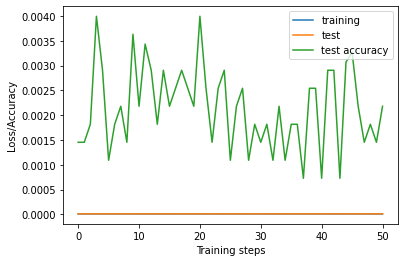

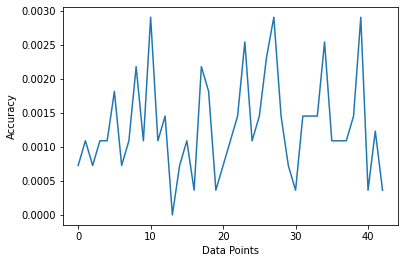

In [11]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()

validate = val_dataset
validate_accuracies = []
for elem in validate:
    validate_loss, validate_accuracy = test(model, val_dataset, cross_entropy_loss)
    validate_accuracies.append(validate_accuracy)

plt.figure()
line1, = plt.plot(validate_accuracies)
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()